In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Torch
import torch
from torch import nn
from torchvision import utils

## Convolutional Auto Encoder 

The following module shows a way to configure PyTorch based ConvAE programatically. I like nn.Sequential() for its simplicity, however, it doesn't support nn.MaxUnpool2d(). So I decided to use nn.ModuleList and construct encoder and decoder dynamically. 

The architecture can be specified using a simple syntax at construction time. It's done in two parts. First, define each kind of module that might be needed and add that to ``ConvAE.modules`` (see few examples below). Next, update input and output dimension for this module in create_layer() function if not already present. When constructing ConvAE, specify the network architecture by passing a list of tuples to ``enc_config`` where each tupe is (< layer_name >, < layer_parameters >).

The decoder is automatically configured using the corresponding encoder layer names prefixed with "de-". MaxUnpool2d needs pooling indices, ConvAE.encode() and ConvAE.decode() show how it's handled here.

To experiment with the depth of the network, simply change layer configuratin in ``enc_config``. If there's a need to experiment with convolution kernel size, make kernel_size parameter configurable using lambda function in addition to D_in and D_out.

In [2]:
def normalize_image(img, mu=0.5, std=1):
    return img.float().div(255).sub(mu).div(std)

def unnormalize_image(img, mu=0.5, std=1):
    return img.mul(std).add(mu).clamp(0,1).mul(255).byte()

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class ConvAE(nn.Module):

    modules = {"conv1": lambda D_in, D_out: nn.Conv2d(D_in, D_out, kernel_size=3, stride=1, padding=1, bias=False),
               "relu1": nn.ReLU,
               "pool1": lambda: nn.MaxPool2d(2, 2, 0, return_indices=True),
               "linear1": lambda N_in, N_out: nn.Linear(N_in, N_out, bias=True),
               "flatten1": Reshape,
               "de-conv1": lambda D_in, D_out: nn.ConvTranspose2d(D_in, D_out, kernel_size=3, stride=1, padding=1, bias=False),
               "de-relu1": nn.ReLU,
               "de-pool1": lambda: nn.MaxUnpool2d(2, 2),
               "de-linear1": lambda N_in, N_out: nn.Linear(N_in, N_out, bias=True),
               "de-flatten1": Reshape,
              }
    
    def __init__(self, input_dim, enc_config = [
                                        ("conv1", 16), ("pool1", None), 
                                        ("flatten1", None), ("linear1", 4096)],
                 verbose=False):
        
        super().__init__()
        self.input_dim = input_dim
        self.verbose = verbose
        
        # Encoder
        self.enc_layers, self.enc_layer_names, self.enc_layer_dims = self.prepare_encoder(input_dim, enc_config)
        self.encoder = nn.ModuleList(self.enc_layers[1:])
        self.code_size = self.enc_layer_dims[-1]
        
        # Decoder
        self.dec_layers, self.dec_layer_names, self.dec_layer_dims = self.prepar_decoder(
            self.enc_layer_names, self.enc_layer_dims)
        self.decoder = nn.ModuleList(self.dec_layers)
        
    def forward(self, images):
        code, pool_idxs = self.encode(images)
        out = self.decode(code, pool_idxs)
        return out, code
    
    def prepare_encoder(self, input_dim, enc_config):
        
        layers = [None]
        layer_names = ["input"]
        layer_dims = [input_dim]
        
        for conf in enc_config:
            
            if self.verbose: print("{} -> {}".format(input_dim, conf))
            
            if len(input_dim) == 1:
                # flat
                layer_name, N_out = conf
                out_dim = (N_out, None)
            else:
                # volume
                layer_name, D_out = conf
                D, H, W = input_dim
                out_dim = (D_out, H, W)
            
            layer, layer_name, out_dim = self.create_layer(layer_name, out_dim, input_dim)
            
            layers.append(layer)
            layer_names.append(layer_name)
            layer_dims.append(out_dim)
            input_dim = out_dim
            
        return layers, layer_names, layer_dims
    
    def prepar_decoder(self, layer_names, layer_dims):
        
        dec_layer_names = ["de-"+l for l in layer_names[::-1]]
        dec_layer_dims = layer_dims[::-1]
        
        layers = []
        layer_names = []
        layer_dims = []
        
        for i, lname in enumerate(dec_layer_names[:-1]):
            
            if self.verbose: print("{} -> {} {}".format(dec_layer_dims[i], lname, dec_layer_dims[i+1]))
            
            layer, layer_name, out_dim = self.create_layer(lname, dec_layer_dims[i+1], dec_layer_dims[i])
            layers.append(layer)
            layer_names.append(layer_name)
            layer_dims.append(out_dim)
        return layers, layer_names, layer_dims
        
    def encode(self, x):
        
        pool_idxs = []
        for i, l in enumerate(ae.encoder):
            if "Pool" in str(l):
                x, idxs = l(x)
                pool_idxs.append(idxs)
            else:
                x = l(x)
        return x, pool_idxs
    
    def decode(self, x, pool_idxs):
        
        for i, l in enumerate(ae.decoder):
            if "Unpool" in str(l):
                x = l(x, pool_idxs.pop())
            else:
                x = l(x)
        return x
    
    def get_results_img(self, x, x_prime, nrows=8, padding=5):
        
        return utils.make_grid(
            torch.stack((x.long(), x_prime.long()), dim=1).view(-1, *self.input_dim),
            nrow=nrows, padding=padding).permute(2, 1, 0).data.numpy().astype(np.uint8)
    
    def create_layer(self, layer_name, out_dim, input_dim):

        layer_fn = ConvAE.modules[layer_name]

        if layer_name.startswith("conv"):

            D, H, W = input_dim
            D_out = out_dim[0]
            layer = layer_fn(D, D_out)
            F, S, P = layer.kernel_size[0], layer.stride[0], layer.padding[0]
            H = W = (W - F + 2*P) // S + 1
            D = D_out
            return layer, layer_name, (D, H, W)

        elif layer_name.startswith("de-conv"):

            D, H, W = input_dim
            D_out = out_dim[0]
            layer = layer_fn(D, D_out)
            F, S, P = layer.kernel_size[0], layer.stride[0], layer.padding[0]
            H = W = (W * S) + max((F-S),0) -2 * P
            D = D_out
            return layer, layer_name, (D, H, W)

        elif layer_name.startswith("pool"):

            D, H, W = input_dim
            layer = layer_fn()
            F, S, P = layer.kernel_size, layer.stride, layer.padding
            H = W = (W - F) // S + 1
            return layer, layer_name, (D, H, W)

        elif layer_name.startswith("de-pool"):

            D, H, W = input_dim
            layer = layer_fn()
            F, S, P = layer.kernel_size[0], layer.stride[0], layer.padding[0]
            H = W = (W - F) // S + 1
            return layer, layer_name, (D, H, W)

        elif  layer_name.startswith("linear"):

            N_in = input_dim[0]
            N_out = out_dim[0]
            layer = layer_fn(N_in, N_out)
            return layer, layer_name, (N_out, )

        elif  layer_name.startswith("de-linear"):

            N_in = input_dim[0]
            N_out = out_dim[0]
            layer = layer_fn(N_in, N_out)
            return layer, layer_name, (N_out, )

        elif layer_name.startswith("flatten"):

            D, H, W = input_dim
            layer = layer_fn(-1, D * H * W)
            return layer, layer_name, (D * H * W, )

        elif layer_name.startswith("de-flatten"):

            D_out, H_out, W_out = out_dim
            layer = layer_fn(-1, D_out, H_out, W_out)
            return layer, layer_name, out_dim

        elif layer_name.startswith("relu") or layer_name.startswith("de-relu"):

            return layer_fn(), layer_name, input_dim

        else:
            raise NotImplementedError("Layer {} not supported!".format(layer_name))

In [3]:
x = torch.randint(0,255, (128,1,64,64))
x = normalize_image(x)
ae = ConvAE(tuple(x.shape[1:]), enc_config = [
    ("conv1", 16), ("relu1", None), ("pool1", None),
    ("conv1", 32), ("relu1", None), ("pool1", None),
    ("flatten1", None), 
    ("linear1", 4096), ("linear1", 1024)],
            verbose=False)
code, idxs = ae.encode(x)
x_prime = ae.decode(code, idxs)

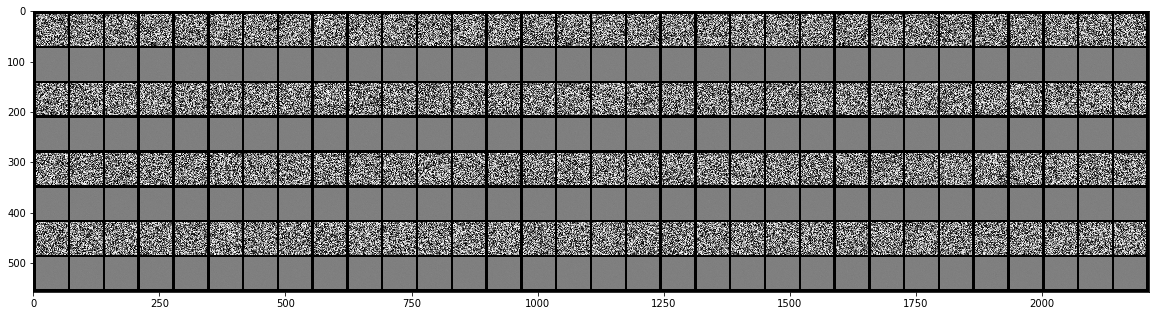

In [5]:
r = ae.get_results_img(unnormalize_image(x), unnormalize_image(x_prime))
plt.figure(figsize=(20,10))
plt.imshow(r.transpose(0,1,2), cmap="gray")

Credits:  
    [1] Sherlock L1aoXingyu. https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/simple_autoencoder.py  
    [2] PyTorch documentation. https://pytorch.org/docs/stable/index.html